In [44]:
import pandas as pd
import seaborn as sns
import toolbox as tbx
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV,cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics
import scipy.stats as st
from sklearn.impute import SimpleImputer
import warnings
import joblib
from math import exp

warnings.filterwarnings('ignore')

In [45]:
data = pd.read_csv('./data/df_final.csv')
data.head()

,BuildingType,PrimaryPropertyType,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,...,ENERGYSTARScore_log,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,Age_log,GFABuildingRate_log,GFAParkingRate_log,NumberOfUses_log,SteamUse_Perc_log,Electricity_Perc_log,NaturalGas_Perc_log
0,NonResidential,Hotel,DOWNTOWN,47.61220,-122.33799,1.0,12,88434,Hotel,88434.0,...,4.094345,15.790918,5.524895,4.488636,0.639219,0.000000,0.000000,3.357942,4.018363,2.926382
1,NonResidential,Hotel,DOWNTOWN,47.61317,-122.33393,1.0,11,103566,Hotel,83880.0,...,4.110874,15.940299,5.692856,2.995732,0.559330,0.135841,1.098612,0.000000,3.680343,4.132603
2,NonResidential,Hotel,DOWNTOWN,47.61393,-122.33810,1.0,41,956110,Hotel,756493.0,...,3.761200,18.100065,7.644996,3.850148,0.524314,0.187060,0.000000,3.424588,4.237434,1.118415
3,NonResidential,Hotel,DOWNTOWN,47.61412,-122.33664,1.0,10,61320,Hotel,61320.0,...,4.025352,15.729160,5.660562,4.499810,0.639219,0.000000,0.000000,3.514228,3.731699,3.319987
4,NonResidential,Hotel,DOWNTOWN,47.61375,-122.34047,1.0,18,175580,Hotel,123445.0,...,4.317488,16.465635,6.226319,3.583519,0.433015,0.302398,1.098612,0.000000,3.660480,4.145038


In [46]:
data_log = data.drop(columns=['Latitude',
 'Longitude',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'Age',
 'GFABuildingRate',
 'GFAParkingRate',
 'NumberOfUses',
 'SteamUse_Perc',
 'Electricity_Perc',
 'NaturalGas_Perc',
 'BuildingType',
 'Neighborhood',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA'])

<AxesSubplot: >

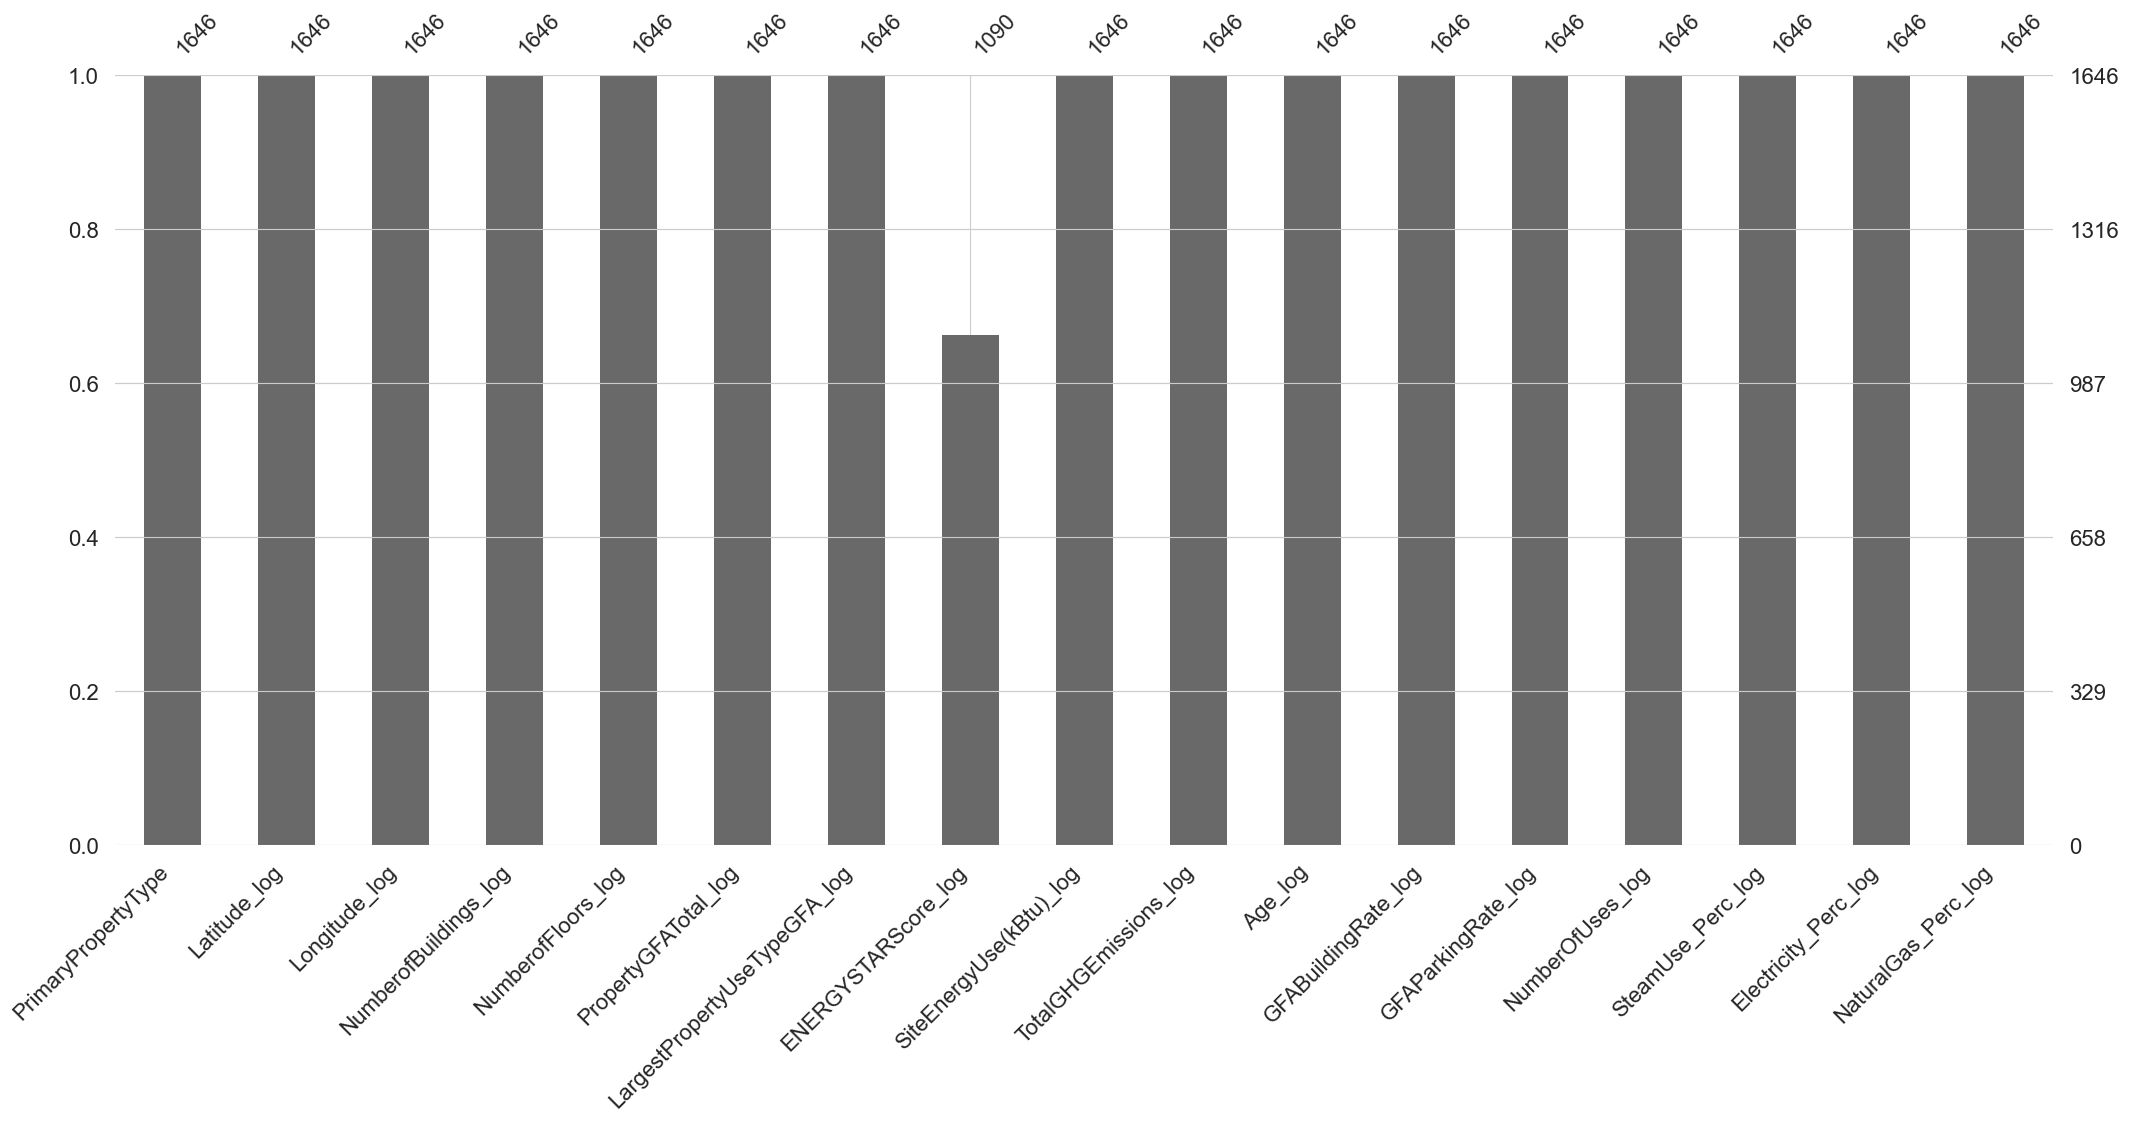

In [47]:
msno.bar(data_log)

La carte de chaleur des corrélations :


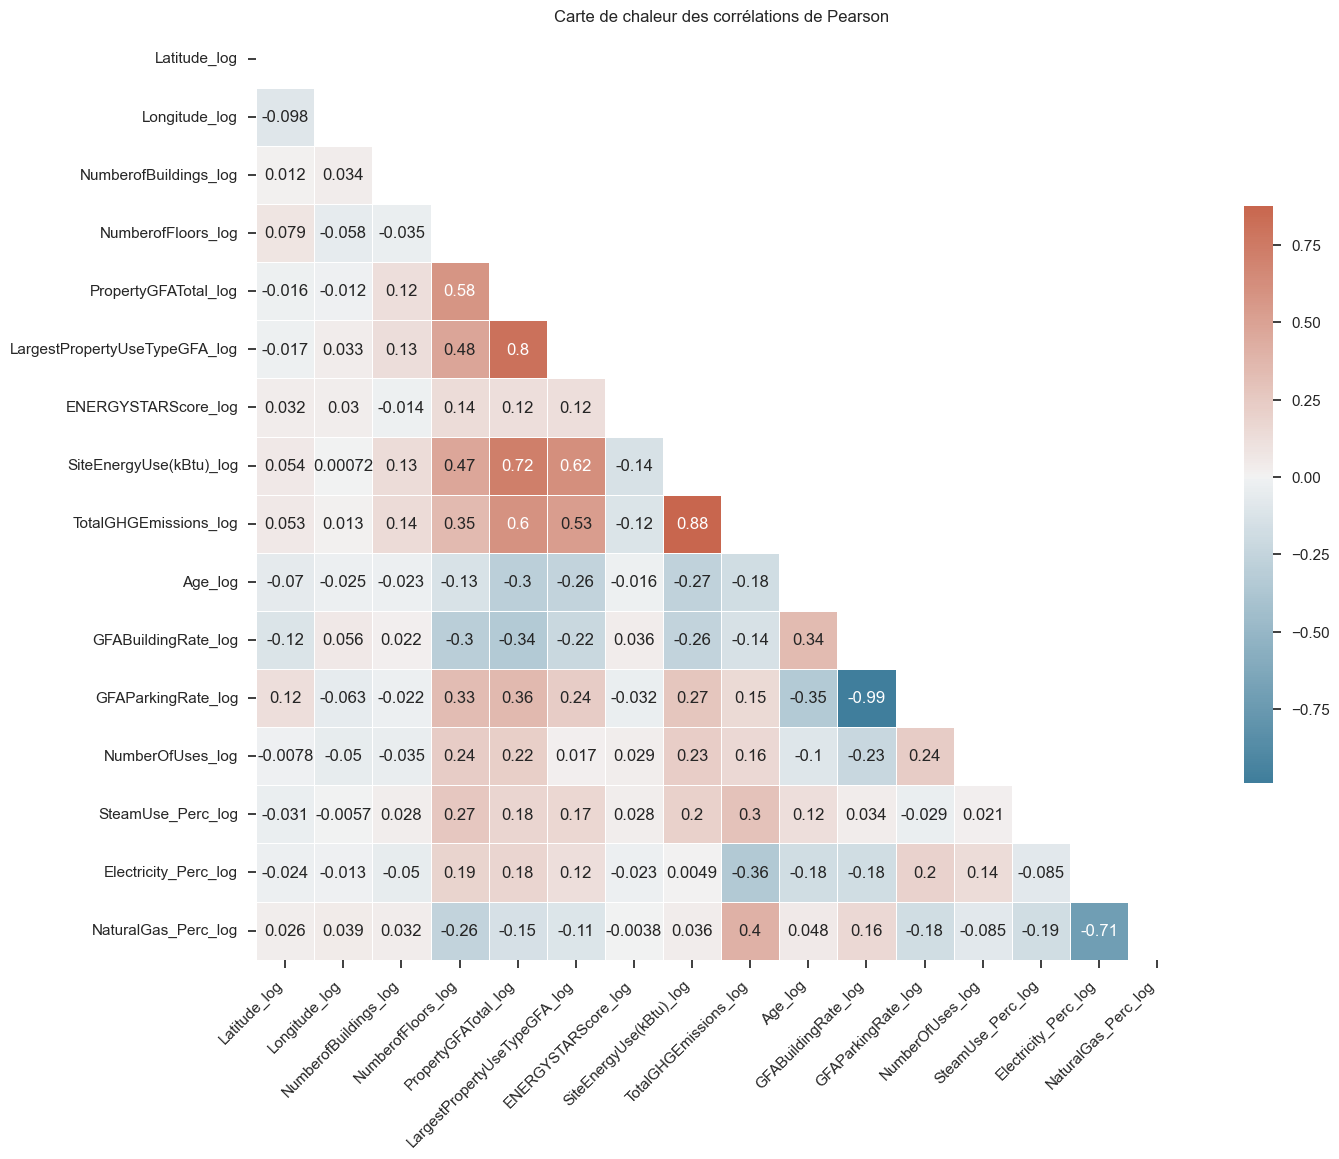

In [48]:
corr_data_num = data_log.corr(method='pearson').copy()

sns.set_context("notebook")

# On genère un masque pour le triangle du dessus
mask_cor = np.triu(np.ones_like(corr_data_num, dtype=bool))

# initialisation de la figure matplotlib
plt.figure(figsize=(15, 15))

# On génère une palette de couleurs personalisée
cmap_cor = sns.diverging_palette(230, 20, as_cmap=True)

# On génère une carte de chaleur avec le masque et le ratio d'aspect
chart = sns.heatmap(corr_data_num, annot=True, fmt=".2g", mask = mask_cor, cmap = cmap_cor, center=0,  
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# annot=True pour voir les valeurs (retirer si trop de cases, que la couleur)
# .1e = scientific notation with 1 decimal point (standard form)
# .2f = 2 decimal places
# .3g = 3 significant figures
# .4% = percentage with 4 decimal places

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Carte de chaleur des corrélations de Pearson')

print("La carte de chaleur des corrélations :")

In [49]:

numerical_features = list(data.select_dtypes(include=["float64","int64"]).columns)
categorical_features = [x for x in data.columns if x not in numerical_features ]

In [50]:
data_model = pd.get_dummies(data=data_log, columns=['PrimaryPropertyType'], prefix='')

data_model


,Latitude_log,Longitude_log,NumberofBuildings_log,NumberofFloors_log,PropertyGFATotal_log,LargestPropertyUseTypeGFA_log,ENERGYSTARScore_log,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,Age_log,...,_Residence Hall,_Restaurant/Bar/Nightclub,_Retail Store,_Self-Storage Facility,_Senior Care Community,_Small- and Mid-Sized Office,_Supermarket / Grocery Store,_University,_Warehouse,_Worship Facility
0,0.107086,0.071232,0.693147,2.564949,11.253507,11.390023,4.094345,15.790918,5.524895,4.488636,...,0,0,0,0,0,0,0,0,0,0
1,0.107957,0.075005,0.693147,2.484907,11.432604,11.337154,4.110874,15.940299,5.692856,2.995732,...,0,0,0,0,0,0,0,0,0,0
2,0.108639,0.071129,0.693147,3.737670,13.758756,13.536450,3.761200,18.100065,7.644996,3.850148,...,0,0,0,0,0,0,0,0,0,0
3,0.108810,0.072488,0.693147,2.397895,10.820498,11.023878,4.025352,15.729160,5.660562,4.499810,...,0,0,0,0,0,0,0,0,0,0
4,0.108478,0.068920,0.693147,2.944439,12.009425,11.723559,4.317488,16.465635,6.226319,3.583519,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,0.065835,0.095565,0.693147,0.693147,6.917706,9.416948,3.828641,13.632714,3.082827,3.258097,...,0,0,0,0,0,0,0,0,0,0
1642,0.092652,0.085251,0.693147,0.693147,8.458716,9.680406,NaN,13.746662,3.498022,2.484907,...,0,0,0,0,0,0,0,0,0,0
1643,0.128631,0.052573,0.693147,0.693147,7.535297,8.933796,NaN,15.564552,5.413519,3.737670,...,0,0,0,0,0,0,0,0,0,0
1644,0.028733,0.083891,0.693147,0.693147,7.943428,8.795128,NaN,13.462633,3.135059,3.295837,...,0,0,0,0,0,0,0,0,0,0


In [51]:
[x for x in data_model.columns if x.startswith('_')]

['_Distribution Center',
 '_Hospital',
 '_Hotel',
 '_K-12 School',
 '_Large Office',
 '_Mixed Use Property',
 '_Office/Medical_Office/Laboratory',
 '_Other',
 '_Refrigerated Warehouse',
 '_Residence Hall',
 '_Restaurant/Bar/Nightclub',
 '_Retail Store',
 '_Self-Storage Facility',
 '_Senior Care Community',
 '_Small- and Mid-Sized Office',
 '_Supermarket / Grocery Store',
 '_University',
 '_Warehouse',
 '_Worship Facility']

In [52]:
for x  in [x for x in data_model.columns if x.startswith('_')]:
        data_model[x] = data_model[x]*data_model['PropertyGFATotal_log']

In [53]:
data_model[data_model['_Retail Store']>0]

,Latitude_log,Longitude_log,NumberofBuildings_log,NumberofFloors_log,PropertyGFATotal_log,LargestPropertyUseTypeGFA_log,ENERGYSTARScore_log,SiteEnergyUse(kBtu)_log,TotalGHGEmissions_log,Age_log,...,_Residence Hall,_Restaurant/Bar/Nightclub,_Retail Store,_Self-Storage Facility,_Senior Care Community,_Small- and Mid-Sized Office,_Supermarket / Grocery Store,_University,_Warehouse,_Worship Facility
62,0.116182,0.071176,0.693147,1.098612,10.758669,11.185435,4.564348,13.847920,3.687378,4.465908,...,0.0,0.0,10.758669,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.189314,0.082796,0.693147,0.693147,13.159187,13.132520,4.584967,17.136951,6.585275,4.174387,...,0.0,0.0,13.159187,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,0.188155,0.082464,0.693147,1.609438,11.635656,11.711785,4.330733,15.984469,4.207376,3.931826,...,0.0,0.0,11.635656,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.023101,0.044543,0.693147,0.693147,10.891168,11.088675,4.276666,14.889655,3.601686,3.912023,...,0.0,0.0,10.891168,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,0.023101,0.044543,0.693147,0.693147,10.941305,11.124067,3.610918,16.036171,5.913557,3.931826,...,0.0,0.0,10.941305,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,0.095619,0.087544,0.693147,1.386294,10.684760,10.914543,4.204693,15.125812,3.693618,2.772589,...,0.0,0.0,10.684760,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1543,0.103937,0.070440,0.693147,1.386294,11.426452,11.542494,4.488636,15.463749,4.407451,3.218876,...,0.0,0.0,11.426452,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1546,0.118281,0.062552,0.693147,1.609438,10.031265,10.556568,NaN,15.080712,3.246491,2.302585,...,0.0,0.0,10.031265,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1548,0.108511,0.086540,0.000000,1.386294,10.447525,10.719825,4.477337,15.482540,4.434738,2.995732,...,0.0,0.0,10.447525,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature selection

In [54]:
data_model.columns

Index(['Latitude_log', 'Longitude_log', 'NumberofBuildings_log',
       'NumberofFloors_log', 'PropertyGFATotal_log',
       'LargestPropertyUseTypeGFA_log', 'ENERGYSTARScore_log',
       'SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log', 'Age_log',
       'GFABuildingRate_log', 'GFAParkingRate_log', 'NumberOfUses_log',
       'SteamUse_Perc_log', 'Electricity_Perc_log', 'NaturalGas_Perc_log',
       '_Distribution Center', '_Hospital', '_Hotel', '_K-12 School',
       '_Large Office', '_Mixed Use Property',
       '_Office/Medical_Office/Laboratory', '_Other',
       '_Refrigerated Warehouse', '_Residence Hall',
       '_Restaurant/Bar/Nightclub', '_Retail Store', '_Self-Storage Facility',
       '_Senior Care Community', '_Small- and Mid-Sized Office',
       '_Supermarket / Grocery Store', '_University', '_Warehouse',
       '_Worship Facility'],
      dtype='object')

In [55]:
X = data_model.drop(columns=[
    'SiteEnergyUse(kBtu)_log', 
    'TotalGHGEmissions_log',
    'ENERGYSTARScore_log',])

y = data_model[['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log','LargestPropertyUseTypeGFA_log']]

In [56]:
import statsmodels.api as sm
X = sm.add_constant(X)


# Implémentation du modèle et entrainement
model_reg_multi = sm.OLS(y['SiteEnergyUse(kBtu)_log'], X).fit()

# Entrainement du modèle
#result=model_reg_multi

print(model_reg_multi.summary())

                               OLS Regression Results                              
Dep. Variable:     SiteEnergyUse(kBtu)_log   R-squared:                       0.675
Model:                                 OLS   Adj. R-squared:                  0.669
Method:                      Least Squares   F-statistic:                     108.1
Date:                     Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                             21:59:39   Log-Likelihood:                -1938.3
No. Observations:                     1646   AIC:                             3941.
Df Residuals:                         1614   BIC:                             4114.
Df Model:                               31                                         
Covariance Type:                 nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [57]:
X.drop(columns=['Latitude_log', 'Longitude_log'], inplace=True)
# Implémentation du modèle et entrainement
model_reg_multi = sm.OLS(y['SiteEnergyUse(kBtu)_log'], X).fit()

# Entrainement du modèle
#result=model_reg_multi

print(model_reg_multi.summary())

                               OLS Regression Results                              
Dep. Variable:     SiteEnergyUse(kBtu)_log   R-squared:                       0.675
Model:                                 OLS   Adj. R-squared:                  0.669
Method:                      Least Squares   F-statistic:                     115.7
Date:                     Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                             21:59:39   Log-Likelihood:                -1938.3
No. Observations:                     1646   AIC:                             3937.
Df Residuals:                         1616   BIC:                             4099.
Df Model:                               29                                         
Covariance Type:                 nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [58]:

X.drop(columns=['_K-12 School'], inplace=True)
# Implémentation du modèle et entrainement
model_reg_multi = sm.OLS(y['SiteEnergyUse(kBtu)_log'], X).fit()

# Entrainement du modèle
#result=model_reg_multi

print(model_reg_multi.summary())

                               OLS Regression Results                              
Dep. Variable:     SiteEnergyUse(kBtu)_log   R-squared:                       0.675
Model:                                 OLS   Adj. R-squared:                  0.669
Method:                      Least Squares   F-statistic:                     115.7
Date:                     Mon, 27 Feb 2023   Prob (F-statistic):               0.00
Time:                             21:59:40   Log-Likelihood:                -1938.3
No. Observations:                     1646   AIC:                             3937.
Df Residuals:                         1616   BIC:                             4099.
Df Model:                               29                                         
Covariance Type:                 nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

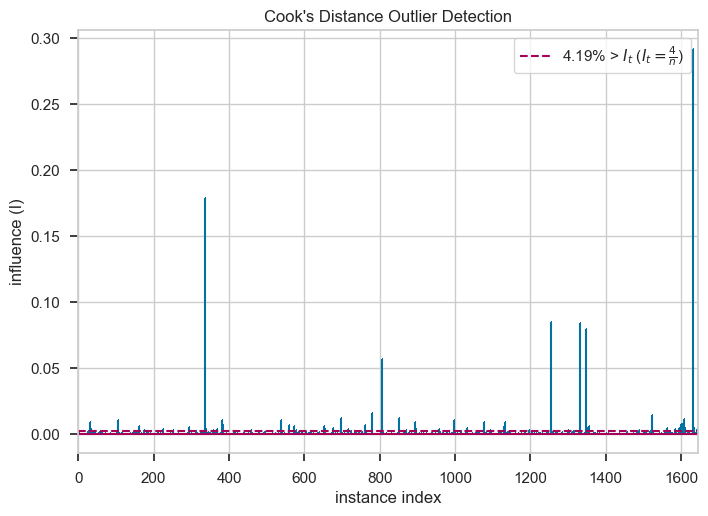

<AxesSubplot: title={'center': "Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [59]:
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete

X = X.drop(columns=['const'])

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X, y['SiteEnergyUse(kBtu)_log'])
visualizer.show()


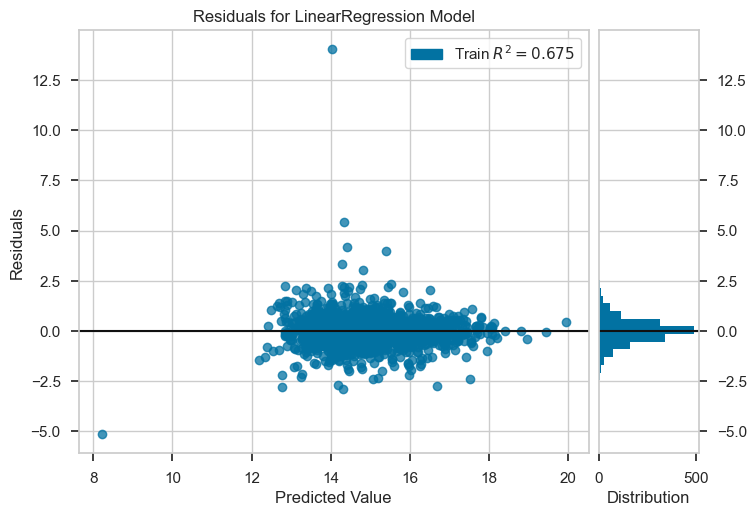

<AxesSubplot: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [60]:
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot

# Instantiate and fit the visualizer
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit( X,y['SiteEnergyUse(kBtu)_log'])
visualizer_residuals.show()

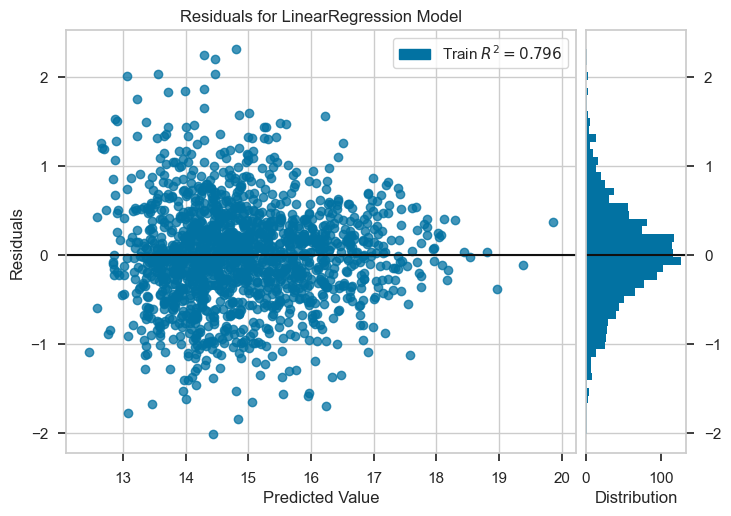

<AxesSubplot: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [61]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = X[i_less_influential], y['SiteEnergyUse(kBtu)_log'][i_less_influential]
X_li_2, y_li_2 = X[i_less_influential], y['TotalGHGEmissions_log'][i_less_influential]

model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
visualizer_residuals.show()

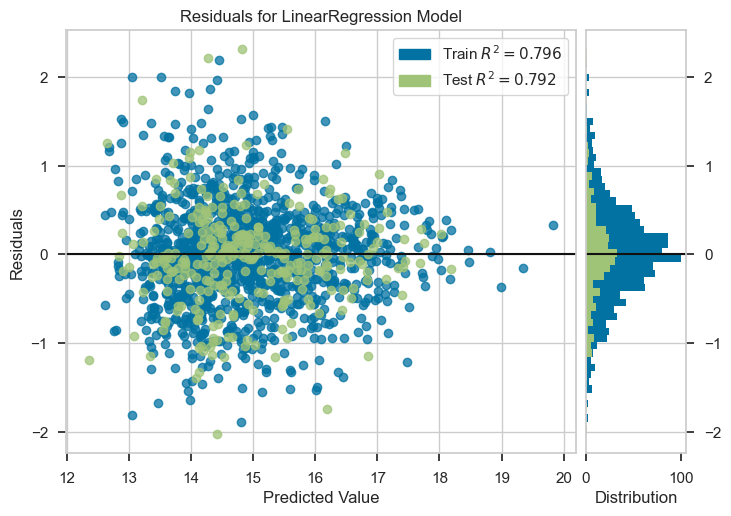

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_li, y_li, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_li_2, y_li_2, test_size=0.2, random_state=42)

from yellowbrick.regressor import residuals_plot
# Create the visualizer, fit, score, and show it
viz = residuals_plot(LinearRegression(), X_train, y_train, X_test, y_test)

In [63]:


%matplotlib inline
from sklearn.preprocessing import  RobustScaler ,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_validate
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error , confusion_matrix,accuracy_score ,r2_score

from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
import time

In [64]:
def test(models, X_train, X_test, y_train, y_test):
    results = []
    for i, model in enumerate(models):
        #  début d'exécution
        start_time = time.time()
        models[model].fit(X_train, y_train)
        y_pred = models[model].predict(X_test)
        # fin d'exécution
        time_end = time.time()
        r2_predict = r2_score(y_test, y_pred)
        MAE = mean_absolute_error(y_test, y_pred)
        MSE = mean_squared_error(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        errors = abs(y_pred - y_test)
       # durée d'exécution
        time_execution = time_end - start_time 
   
    
        results.append([r2_predict,MAE,MSE,RMSE,np.mean(errors),time_execution])
    return pd.DataFrame(results, columns=["R2 Score",'MAE','MSE','RMSE','Erreur moy','Durée(sec)'], index=models.keys())


In [65]:
models = {'Linear': LinearRegression(),
          'Lasso': Lasso(),
          'Ridge': Ridge(),
          'Random Forest': RandomForestRegressor(),
          'XGBR': XGBRegressor(),
          'GBR':GradientBoostingRegressor(),
       
         }

In [66]:
baseline_seu = test( models,X_train, X_test, y_train, y_test).reset_index()
baseline_seu.rename(columns={'index':'Model'}, inplace=True)
baseline_seu['target'] ='SiteEnergyUse(kBtu)_log'
baseline_te = test( models,X_train_2, X_test_2, y_train_2, y_test_2).reset_index()
baseline_te.rename(columns={'index':'Model'}, inplace=True)
baseline_te['target'] ='TotalGHGEmissions_log'
print('Site Energy Use')
display(baseline_seu)
print('Total emission')
display(baseline_te)
baseline = baseline_seu.append(baseline_te)

Site Energy Use


,Model,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec),target
0,Linear,0.791599,0.399404,0.308191,0.555150,0.399404,0.005065,SiteEnergyUse(kBtu)_log
1,Lasso,0.189311,0.863452,1.198880,1.094934,0.863452,0.009792,SiteEnergyUse(kBtu)_log
2,Ridge,0.790641,0.400845,0.309609,0.556425,0.400845,0.016102,SiteEnergyUse(kBtu)_log
3,Random Forest,0.752773,0.440886,0.365610,0.604657,0.440886,0.568712,SiteEnergyUse(kBtu)_log
4,XGBR,0.747663,0.445538,0.373166,0.610873,0.445538,1.010243,SiteEnergyUse(kBtu)_log
5,GBR,0.770879,0.426824,0.338833,0.582094,0.426824,0.160449,SiteEnergyUse(kBtu)_log


Total emission


,Model,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec),target
0,Linear,0.836210,0.398104,0.282962,0.531941,0.398104,0.006445,TotalGHGEmissions_log
1,Lasso,0.069492,1.006298,1.607531,1.267884,1.006298,0.006648,TotalGHGEmissions_log
2,Ridge,0.835631,0.396379,0.283961,0.532880,0.396379,0.013420,TotalGHGEmissions_log
3,Random Forest,0.777213,0.460843,0.384884,0.620390,0.460843,0.549546,TotalGHGEmissions_log
4,XGBR,0.769389,0.458700,0.398400,0.631190,0.458700,0.751523,TotalGHGEmissions_log
5,GBR,0.797351,0.439011,0.350094,0.591687,0.439011,0.153610,TotalGHGEmissions_log


### Cross validation

In [67]:
def compute_cross_val(models, X, y, target, with_energystar_score):
    scores = {}   
    for key, value in models.items():
        folds = KFold(n_splits = 5, shuffle = True, random_state = 42)    
        score = cross_val_score(value, X, y, scoring='r2', cv=folds)
        score_2 = np.append(score, score.mean())
        scores.update({key:score_2})
    
    index_liste=[]
    for i in range(1, 6):
        index_liste.append(f'fold_{i}')
    
    index_liste.append('mean')
    
    crov_val_df = pd.DataFrame(scores, index=index_liste)
    crov_val_df['Target'] = target
    crov_val_df['with_energystar_score'] = with_energystar_score
    

    return crov_val_df

In [68]:
compute_cross_val(models, X=X_train, y=y_train, target ='TotalGHGEmissions_log', with_energystar_score=False)

,Linear,Lasso,Ridge,Random Forest,XGBR,GBR,Target,with_energystar_score
fold_1,0.769707,0.171898,0.767914,0.701450,0.702392,0.735151,TotalGHGEmissions_log,False
fold_2,0.777512,0.172181,0.777699,0.731773,0.716731,0.768505,TotalGHGEmissions_log,False
fold_3,0.779265,0.148862,0.776309,0.729540,0.707829,0.755719,TotalGHGEmissions_log,False
fold_4,0.801650,0.147666,0.802107,0.737031,0.722933,0.763467,TotalGHGEmissions_log,False
fold_5,0.791496,0.104914,0.793400,0.780918,0.757179,0.786030,TotalGHGEmissions_log,False
mean,0.783926,0.149104,0.783486,0.736142,0.721413,0.761774,TotalGHGEmissions_log,False


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


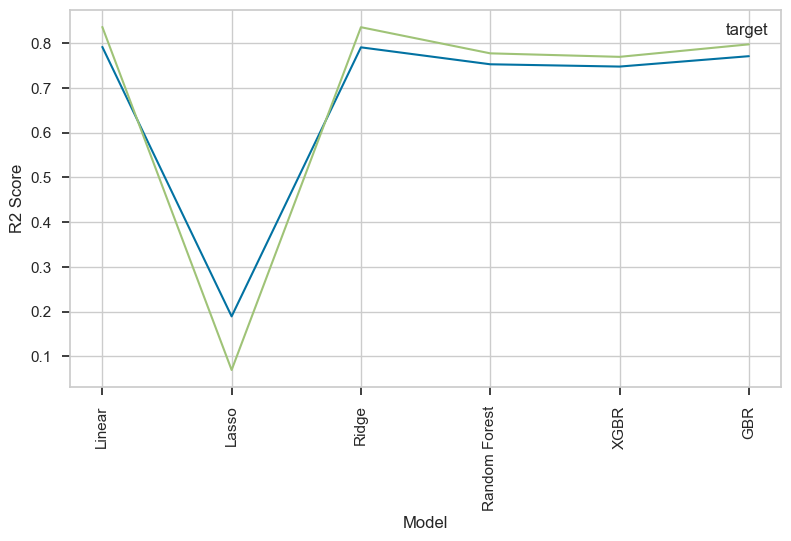

In [69]:

sns.lineplot(x='Model', y="R2 Score",
                data=baseline,
                hue='target',
                #kind="bar",
                legend=False)
plt.legend(loc='upper right', fontsize='small',title="target")
plt.xticks(rotation =90)
# scaling automatique ('paper', 'talk', 'poster', 'notebook')
sns.set_context("paper")
# Tweak spacing to prevent clipping of ylabel
plt.tight_layout()

In [70]:
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from math import sqrt

from time import time
from pprint import pprint

from sklearn.linear_model import LinearRegression, Ridge,Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import GridSearchCV

In [71]:


def run_model(X_train, X_test, y_train, y_test, model, model_name, train_time=0, log=False):
    ''' Fonction qui lance un modèle de machine learning 
    et retourne un dataset avec les différentes métriques.
    Si log=True on considère que la variable cible a 
    été passée au log lors du preprocessing. '''
    try:
        print('Paramètres du modèle', model_name, ':')
        pprint(model.get_params())
    except:
        pass
    
    if train_time == 0:
        start = time()
        model.fit(X_train, y_train)
        train_time = time() - start   
    
    start = time()
    pred_train = model.predict(X_train)
    predict_time_train = time()-start
    
    start = time()
    pred_test = model.predict(X_test)
    predict_time_test = time()-start  

    R2_train = model.score(X_train,y_train)
         
    if log == True:
        y_train, y_test, pred_train, pred_test =  np.expm1(y_train), np.expm1(y_test), np.expm1(pred_train), np.expm1(pred_test)

    RMSE_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    R2_test = r2_score(y_test,pred_test)
    RMSE_test = np.sqrt(metrics.mean_squared_error(y_test,pred_test))
    
    
    data = {'training_time': train_time, 'R2_train': R2_train,
            'RMSE_train': RMSE_train, 'predict_time_train': predict_time_train, 'R2_test': R2_test,
            'RMSE_test': RMSE_test, 'predict_time_test':predict_time_test}
    
    
    return pd.DataFrame(data, index = [model_name])


def test_models(X_train, X_test, y_train, y_test):
    ''' Fonction pour tester différents modèles
    avec paramètres par défaut. '''
    
    regressors = [
        GradientBoostingRegressor(),
        RandomForestRegressor(),
        LinearRegression(),
        Lasso(),
        Ridge(),
        ElasticNet(),
        DummyRegressor(strategy='mean'),
    ]

    test_models = pd.DataFrame()

    for model in regressors:
        test_models = pd.concat([test_models, run_model(X_train, X_test, y_train, y_test, model, str(model))])

    return test_models

se = test_models(X_train, X_test, y_train, y_test)
se['target'] = 'seu'
te = test_models(X_train_2, X_test_2, y_train_2, y_test_2)
te['target'] = 'te'

results = se.append(te)

Paramètres du modèle GradientBoostingRegressor() :
{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
Paramètres du modèle RandomForestRegressor() :
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Paramètres du modèle LinearRe

In [72]:
print('*'*25,'Site Energy Use','*'*25)
display(se)
print('*'*25,'Total emission','*'*25)
display(te)

************************* Site Energy Use *************************


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test,target
GradientBoostingRegressor(),0.158566,0.848277,0.494561,0.001764,0.768835,0.584684,0.000816,seu
RandomForestRegressor(),0.433851,0.964785,0.238262,0.015576,0.755160,0.601730,0.006140,seu
LinearRegression(),0.001723,0.795837,0.573697,0.009518,0.791599,0.555150,0.000359,seu
Lasso(),0.060649,0.147165,1.172536,0.044789,0.189311,1.094934,0.001886,seu
Ridge(),0.007437,0.795087,0.574750,0.005998,0.790641,0.556425,0.000393,seu
ElasticNet(),0.017970,0.451166,0.940620,0.005302,0.473914,0.882041,0.000396,seu
DummyRegressor(),0.000082,0.000000,1.269678,0.000018,-0.001965,1.217270,0.000011,seu


************************* Total emission *************************


,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test,target
GradientBoostingRegressor(),0.269667,0.891091,0.469498,0.001777,0.797229,0.591864,0.000677,te
RandomForestRegressor(),0.390335,0.972770,0.234762,0.015030,0.771395,0.628437,0.006446,te
LinearRegression(),0.001730,0.845477,0.559239,0.009556,0.836210,0.531941,0.011558,te
Lasso(),0.054336,0.074613,1.368557,0.008309,0.069492,1.267884,0.001901,te
Ridge(),0.004703,0.844774,0.560510,0.036856,0.835631,0.532880,0.004709,te
ElasticNet(),0.128624,0.457762,1.047602,0.083364,0.438756,0.984680,0.000825,te
DummyRegressor(),0.000589,0.000000,1.422660,0.000058,-0.003768,1.316849,0.000038,te


In [73]:
#data_log = data_log.drop(columns=['Latitude_log', 'Longitude_log'])
numerical_features = list(data_log.select_dtypes(include=["float64","int64"]).columns)
categorical_features = [x for x in data_log.columns if x not in numerical_features ]

In [74]:
X = data_model.drop(columns=[
    'SiteEnergyUse(kBtu)_log', 
    'TotalGHGEmissions_log',])

y = data_model[['SiteEnergyUse(kBtu)_log', 'TotalGHGEmissions_log',]]


numerical_features = list(X.select_dtypes(include=["float64","int64"]).columns)
categorical_features = [x for x in X.columns if x not in numerical_features ]

In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

full_pipeline = ColumnTransformer([
    ("num", Pipeline([('imputer', SimpleImputer(strategy ="median")),
                         ('std_scaler', StandardScaler())]), numerical_features)])

X_prepared = full_pipeline.fit_transform(X)
X_prep = pd.DataFrame(X_prepared, columns=X.columns)
X_prep_2 = X_prep.drop(columns='ENERGYSTARScore_log')

In [76]:

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_prep, data_log["SiteEnergyUse(kBtu)_log"], test_size=0.2, random_state=42)
ess_seu = test_models(X_train_3, X_test_3, y_train_3, y_test_3)
ess_seu['energy_star_score'] = 'in'
ess_seu['target'] = 'SiteEnergyUse(kBtu)_log'


X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_prep_2, data_log["SiteEnergyUse(kBtu)_log"], test_size=0.2, random_state=42)
sess_seu = test_models(X_train_4, X_test_4, y_train_4, y_test_4)
sess_seu['energy_star_score'] = 'out'
sess_seu['target'] = 'SiteEnergyUse(kBtu)_log'


X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_prep, data_log["TotalGHGEmissions_log"], test_size=0.2, random_state=42)
ess_te = test_models(X_train_3, X_test_3, y_train_3, y_test_3)
ess_te['energy_star_score'] = 'in'
ess_te['target'] = 'TotalGHGEmissions_log'

X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_prep_2, data_log["TotalGHGEmissions_log"], test_size=0.2, random_state=42)
sess_te = test_models(X_train_3, X_test_3, y_train_3, y_test_3)
sess_te['energy_star_score'] = 'out'
sess_te['target'] = 'TotalGHGEmissions_log'


results = ess_seu.append(sess_seu).append(ess_te).append(sess_te)


Paramètres du modèle GradientBoostingRegressor() :
{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}
Paramètres du modèle RandomForestRegressor() :
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Paramètres du modèle LinearRe

In [77]:
results = results.reset_index()
results.rename(columns={'index':'Model'}, inplace=True)
results

,Model,training_time,R2_train,RMSE_train,predict_time_train,R2_test,RMSE_test,predict_time_test,energy_star_score,target
0,GradientBoostingRegressor(),0.225108,0.865455,0.508242,0.002086,0.835099,0.546099,0.000761,in,SiteEnergyUse(kBtu)_log
1,RandomForestRegressor(),0.594674,0.954726,0.294822,0.016259,0.818690,0.572626,0.006363,in,SiteEnergyUse(kBtu)_log
2,LinearRegression(),0.003847,0.680317,0.783422,0.025806,0.821994,0.567384,0.001846,in,SiteEnergyUse(kBtu)_log
3,Lasso(),0.022625,0.000000,1.385595,0.007522,-0.003837,1.347386,0.016989,in,SiteEnergyUse(kBtu)_log
4,Ridge(),0.042532,0.680314,0.783426,0.020371,0.822110,0.567199,0.043151,in,SiteEnergyUse(kBtu)_log
5,ElasticNet(),0.090860,0.284224,1.172262,0.012969,0.333211,1.098132,0.092775,in,SiteEnergyUse(kBtu)_log
6,DummyRegressor(),0.000299,0.000000,1.385595,0.000057,-0.003837,1.347386,0.000033,in,SiteEnergyUse(kBtu)_log
7,GradientBoostingRegressor(),0.302978,0.839603,0.554925,0.001904,0.772208,0.641843,0.000809,out,SiteEnergyUse(kBtu)_log
8,RandomForestRegressor(),0.562921,0.944149,0.327455,0.017027,0.783264,0.626074,0.007156,out,SiteEnergyUse(kBtu)_log
9,LinearRegression(),0.002006,0.648056,0.822003,0.018459,0.780985,0.629357,0.017767,out,SiteEnergyUse(kBtu)_log


### Cross Validation - Baseline

In [78]:
display(compute_cross_val(models, X_prep, y["SiteEnergyUse(kBtu)_log"], target ='SiteEnergyUse(kBtu)_log', with_energystar_score=True))
display(compute_cross_val(models, X_prep_2, y["SiteEnergyUse(kBtu)_log"], target ='SiteEnergyUse(kBtu)_log', with_energystar_score=False))
display(compute_cross_val(models, X_prep, y["TotalGHGEmissions_log"], target ='TotalGHGEmissions_log', with_energystar_score=True))
display(compute_cross_val(models, X_prep_2, y["TotalGHGEmissions_log"], target ='TotalGHGEmissions_log', with_energystar_score=False))

,Linear,Lasso,Ridge,Random Forest,XGBR,GBR,Target,with_energystar_score
fold_1,0.821933,-0.003837,0.822110,0.826757,0.798614,0.834635,SiteEnergyUse(kBtu)_log,True
fold_2,0.595390,-0.000251,0.595557,0.600857,0.631031,0.622102,SiteEnergyUse(kBtu)_log,True
fold_3,0.675714,0.016988,0.675702,0.668456,0.738614,0.731580,SiteEnergyUse(kBtu)_log,True
fold_4,0.632111,0.000798,0.632825,0.741173,0.764212,0.745131,SiteEnergyUse(kBtu)_log,True
fold_5,0.592341,-0.000022,0.593176,0.725278,0.746152,0.765996,SiteEnergyUse(kBtu)_log,True
mean,0.663498,0.002735,0.663874,0.712504,0.735725,0.739889,SiteEnergyUse(kBtu)_log,True


,Linear,Lasso,Ridge,Random Forest,XGBR,GBR,Target,with_energystar_score
fold_1,0.780941,-0.003837,0.781377,0.788346,0.735581,0.773538,SiteEnergyUse(kBtu)_log,False
fold_2,0.567917,-0.000251,0.568024,0.569745,0.592441,0.593530,SiteEnergyUse(kBtu)_log,False
fold_3,0.627742,0.016988,0.627671,0.608650,0.631693,0.649994,SiteEnergyUse(kBtu)_log,False
fold_4,0.606774,0.000798,0.607373,0.669720,0.680561,0.689150,SiteEnergyUse(kBtu)_log,False
fold_5,0.553366,-0.000022,0.571082,0.689118,0.668444,0.695820,SiteEnergyUse(kBtu)_log,False
mean,0.627348,0.002735,0.631106,0.665116,0.661744,0.680407,SiteEnergyUse(kBtu)_log,False


,Linear,Lasso,Ridge,Random Forest,XGBR,GBR,Target,with_energystar_score
fold_1,0.863887,-0.001588,0.863983,0.843073,0.855557,0.870316,TotalGHGEmissions_log,True
fold_2,0.824513,-0.001116,0.824626,0.811579,0.841744,0.858093,TotalGHGEmissions_log,True
fold_3,0.759919,-0.001172,0.759958,0.762964,0.780105,0.802777,TotalGHGEmissions_log,True
fold_4,0.752183,-0.003229,0.752639,0.779962,0.814141,0.823697,TotalGHGEmissions_log,True
fold_5,0.676476,-0.001334,0.676973,0.745264,0.791568,0.823954,TotalGHGEmissions_log,True
mean,0.775396,-0.001688,0.775636,0.788568,0.816623,0.835767,TotalGHGEmissions_log,True


,Linear,Lasso,Ridge,Random Forest,XGBR,GBR,Target,with_energystar_score
fold_1,0.835260,-0.001588,0.835600,0.816403,0.814634,0.844943,TotalGHGEmissions_log,False
fold_2,0.795191,-0.001116,0.795268,0.788012,0.811666,0.817230,TotalGHGEmissions_log,False
fold_3,0.726235,-0.001172,0.726165,0.742653,0.748783,0.754466,TotalGHGEmissions_log,False
fold_4,0.737612,-0.003229,0.737804,0.755504,0.774920,0.787650,TotalGHGEmissions_log,False
fold_5,0.629710,-0.001334,0.658603,0.727070,0.735080,0.763322,TotalGHGEmissions_log,False
mean,0.744802,-0.001688,0.750688,0.765928,0.777017,0.793522,TotalGHGEmissions_log,False


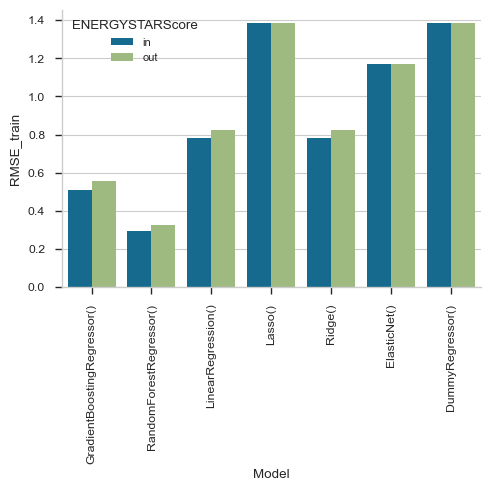

In [79]:

sns.catplot(x='Model', y="RMSE_train",
                hue="energy_star_score",
                data=results[results['target']=='SiteEnergyUse(kBtu)_log'],
                kind="bar", legend=False)

plt.legend(loc='upper left', fontsize='small',title="ENERGYSTARScore")
plt.xticks(rotation =90)
# scaling automatique ('paper', 'talk', 'poster', 'notebook')
sns.set_context("paper")
# Tweak spacing to prevent clipping of ylabel
plt.tight_layout()

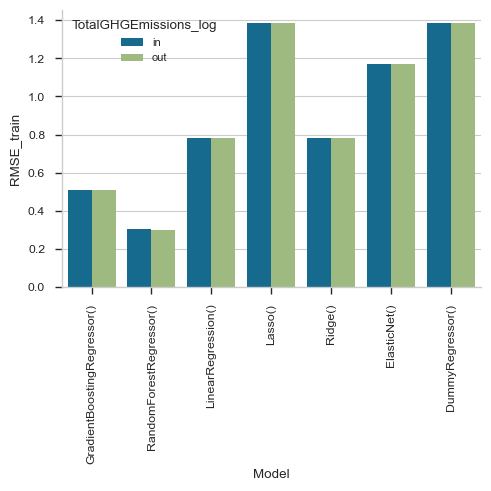

In [80]:

sns.catplot(x='Model', y="RMSE_train",
                hue="energy_star_score",
                data=results[results['target']=='TotalGHGEmissions_log'],
                kind="bar", legend=False)

plt.legend(loc='upper left', fontsize='small',title="TotalGHGEmissions_log")
plt.xticks(rotation =90)
# scaling automatique ('paper', 'talk', 'poster', 'notebook')
sns.set_context("paper")
# Tweak spacing to prevent clipping of ylabel
plt.tight_layout()

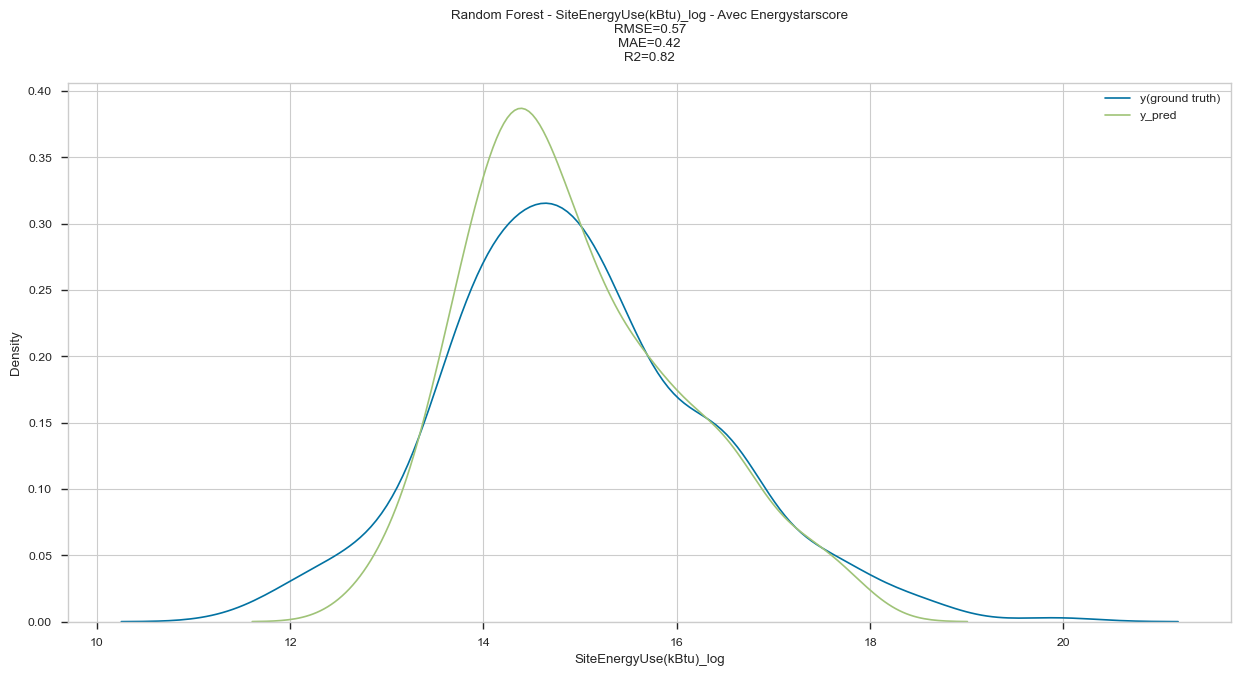

In [81]:
best_reg= RandomForestRegressor()
best_reg.fit(X_train_3, y_train_3)

final_predictions = best_reg.predict(X_test_3)

# pour SiteEnergyUse(kBtu)_log
title = "Random Forest - SiteEnergyUse(kBtu)_log - Avec Energystarscore"
plt.figure(figsize=(15,7))
sns.kdeplot(y_test_3, label='y(ground truth)')
sns.kdeplot(final_predictions, label='y_pred')
plt.title(f"""{title}
RMSE={round(mean_squared_error(y_test_3,final_predictions, squared=False),2)}
MAE={round(mean_absolute_error(y_test_3, final_predictions),2)}
R2={round(r2_score(y_test_4, final_predictions),2)}
""")
plt.legend()

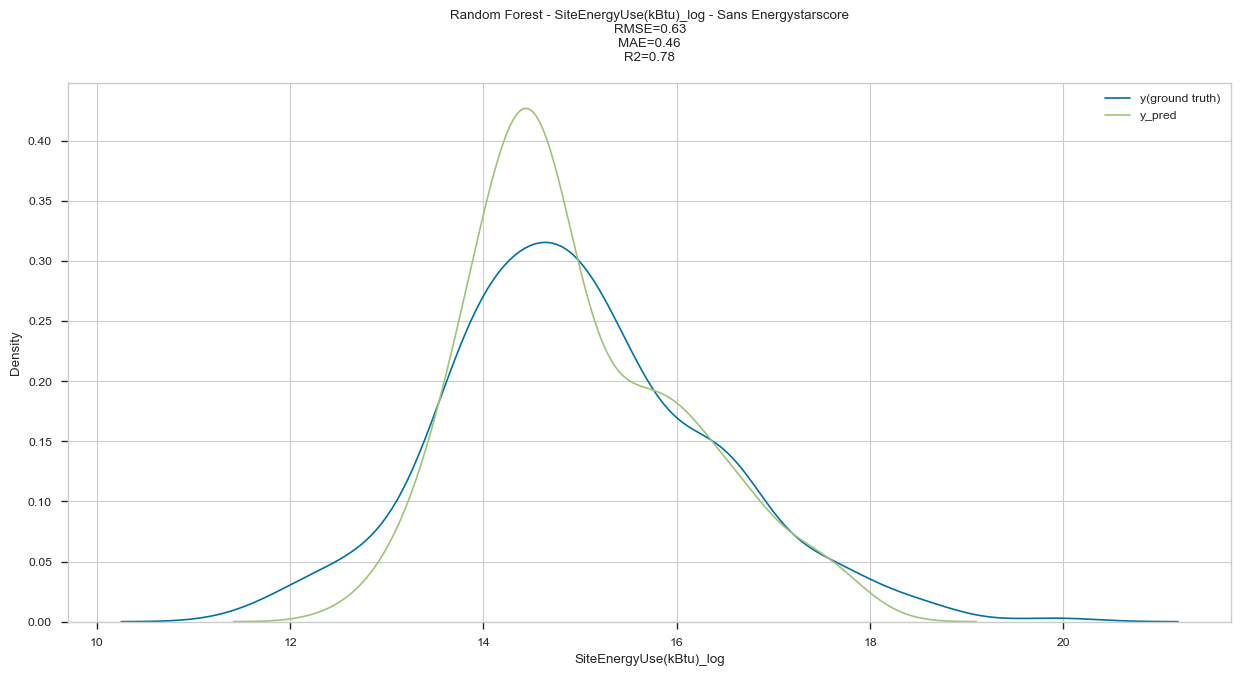

In [82]:
best_reg= RandomForestRegressor()
best_reg.fit(X_train_4, y_train_4)

final_predictions = best_reg.predict(X_test_4)

# pour SiteEnergyUse(kBtu)_log
title = "Random Forest - SiteEnergyUse(kBtu)_log - Sans Energystarscore"
plt.figure(figsize=(15,7))
sns.kdeplot(y_test_4, label='y(ground truth)')
sns.kdeplot(final_predictions, label='y_pred')
plt.title(f"""{title}
RMSE={round(mean_squared_error(y_test_4,final_predictions, squared=False),2)}
MAE={round(mean_absolute_error(y_test_4, final_predictions),2)}
R2={round(r2_score(y_test_4, final_predictions),2)}
""")
plt.legend()

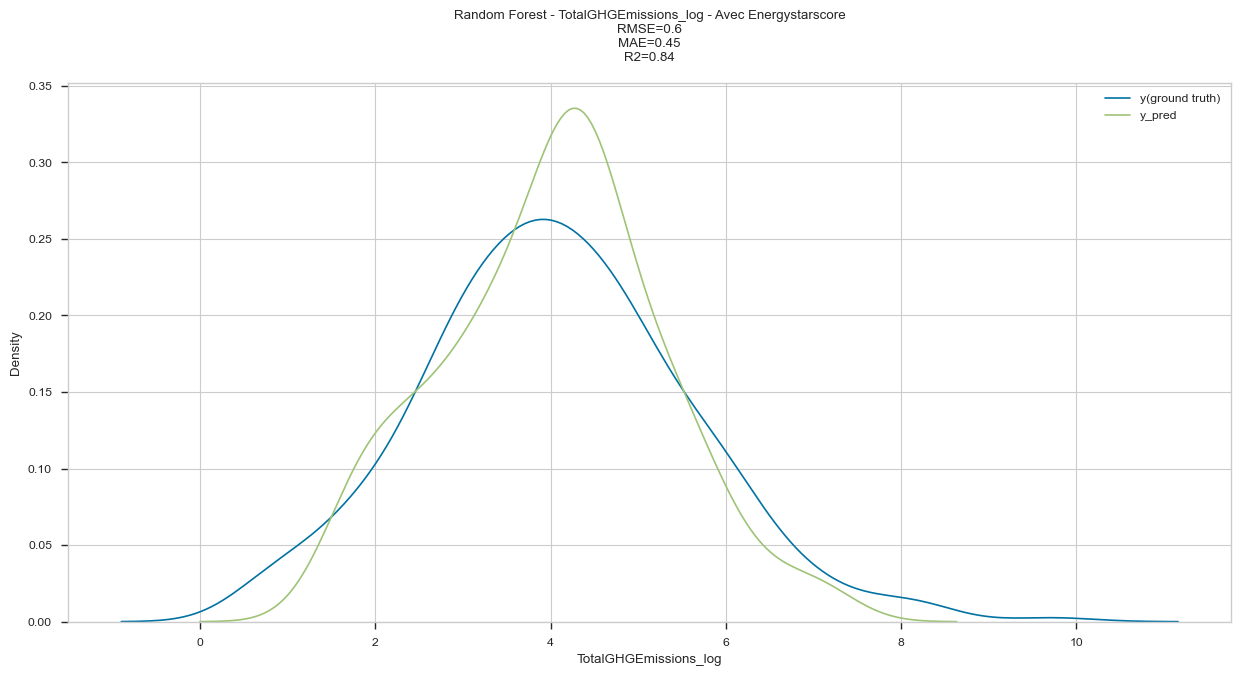

In [83]:
best_reg= RandomForestRegressor()
best_reg.fit(X_train_5, y_train_5)

final_predictions = best_reg.predict(X_test_5)

# pour SiteEnergyUse(kBtu)_log
title = "Random Forest - TotalGHGEmissions_log - Avec Energystarscore"
plt.figure(figsize=(15,7))
sns.kdeplot(y_test_5, label='y(ground truth)')
sns.kdeplot(final_predictions, label='y_pred')
plt.title(f"""{title}
RMSE={round(mean_squared_error(y_test_5,final_predictions, squared=False),2)}
MAE={round(mean_absolute_error(y_test_5, final_predictions),2)}
R2={round(r2_score(y_test_5, final_predictions),2)}
""")
plt.legend()

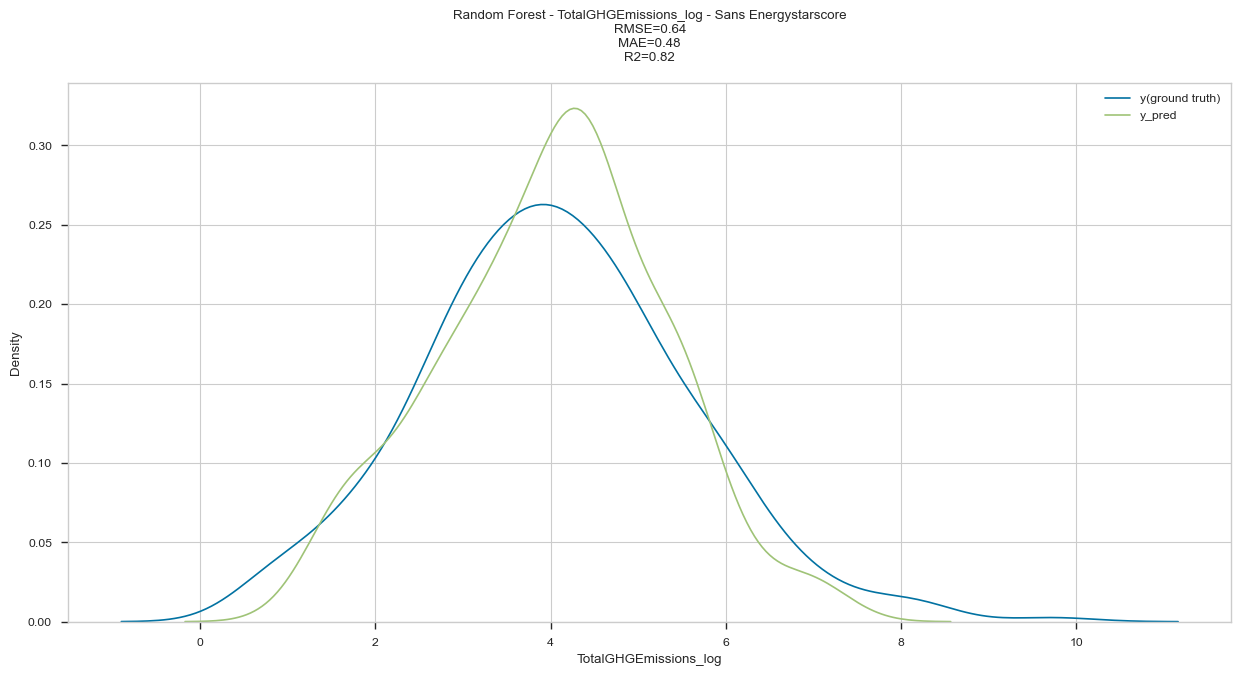

In [84]:
best_reg= RandomForestRegressor()
best_reg.fit(X_train_6, y_train_6)

final_predictions = best_reg.predict(X_test_6)

# pour SiteEnergyUse(kBtu)_log
title = "Random Forest - TotalGHGEmissions_log - Sans Energystarscore"
plt.figure(figsize=(15,7))
sns.kdeplot(y_test_6, label='y(ground truth)')
sns.kdeplot(final_predictions, label='y_pred')
plt.title(f"""{title}
RMSE={round(mean_squared_error(y_test_6,final_predictions, squared=False),2)}
MAE={round(mean_absolute_error(y_test_5, final_predictions),2)}
R2={round(r2_score(y_test_6, final_predictions),2)}
""")
plt.legend()

## Cross validation 

In [85]:
display(compute_cross_val(models, X_prep, y["SiteEnergyUse(kBtu)_log"], target ='SiteEnergyUse(kBtu)_log', with_energystar_score=True))
display(compute_cross_val(models, X_prep_2, y["SiteEnergyUse(kBtu)_log"], target ='SiteEnergyUse(kBtu)_log', with_energystar_score=False))
display(compute_cross_val(models, X_prep, y["SiteEnergyUse(kBtu)_log"], target ='TotalGHGEmissions_log', with_energystar_score=True))
display(compute_cross_val(models, X_prep_2, y["SiteEnergyUse(kBtu)_log"], target ='TotalGHGEmissions_log', with_energystar_score=False))

,Linear,Lasso,Ridge,Random Forest,XGBR,GBR,Target,with_energystar_score
fold_1,0.821933,-0.003837,0.822110,0.825051,0.798614,0.835139,SiteEnergyUse(kBtu)_log,True
fold_2,0.595390,-0.000251,0.595557,0.602452,0.631031,0.621802,SiteEnergyUse(kBtu)_log,True
fold_3,0.675714,0.016988,0.675702,0.664327,0.738614,0.743141,SiteEnergyUse(kBtu)_log,True
fold_4,0.632111,0.000798,0.632825,0.737394,0.764212,0.746213,SiteEnergyUse(kBtu)_log,True
fold_5,0.592341,-0.000022,0.593176,0.734439,0.746152,0.777594,SiteEnergyUse(kBtu)_log,True
mean,0.663498,0.002735,0.663874,0.712733,0.735725,0.744778,SiteEnergyUse(kBtu)_log,True


,Linear,Lasso,Ridge,Random Forest,XGBR,GBR,Target,with_energystar_score
fold_1,0.780941,-0.003837,0.781377,0.783789,0.735581,0.772535,SiteEnergyUse(kBtu)_log,False
fold_2,0.567917,-0.000251,0.568024,0.561746,0.592441,0.594587,SiteEnergyUse(kBtu)_log,False
fold_3,0.627742,0.016988,0.627671,0.604035,0.631693,0.650719,SiteEnergyUse(kBtu)_log,False
fold_4,0.606774,0.000798,0.607373,0.670592,0.680561,0.689558,SiteEnergyUse(kBtu)_log,False
fold_5,0.553366,-0.000022,0.571082,0.695218,0.668444,0.711963,SiteEnergyUse(kBtu)_log,False
mean,0.627348,0.002735,0.631106,0.663076,0.661744,0.683872,SiteEnergyUse(kBtu)_log,False


,Linear,Lasso,Ridge,Random Forest,XGBR,GBR,Target,with_energystar_score
fold_1,0.821933,-0.003837,0.822110,0.823652,0.798614,0.835085,TotalGHGEmissions_log,True
fold_2,0.595390,-0.000251,0.595557,0.598426,0.631031,0.623429,TotalGHGEmissions_log,True
fold_3,0.675714,0.016988,0.675702,0.671617,0.738614,0.733484,TotalGHGEmissions_log,True
fold_4,0.632111,0.000798,0.632825,0.740515,0.764212,0.746540,TotalGHGEmissions_log,True
fold_5,0.592341,-0.000022,0.593176,0.727357,0.746152,0.751189,TotalGHGEmissions_log,True
mean,0.663498,0.002735,0.663874,0.712313,0.735725,0.737946,TotalGHGEmissions_log,True


,Linear,Lasso,Ridge,Random Forest,XGBR,GBR,Target,with_energystar_score
fold_1,0.780941,-0.003837,0.781377,0.784579,0.735581,0.772600,TotalGHGEmissions_log,False
fold_2,0.567917,-0.000251,0.568024,0.568295,0.592441,0.592771,TotalGHGEmissions_log,False
fold_3,0.627742,0.016988,0.627671,0.611269,0.631693,0.649194,TotalGHGEmissions_log,False
fold_4,0.606774,0.000798,0.607373,0.676799,0.680561,0.689405,TotalGHGEmissions_log,False
fold_5,0.553366,-0.000022,0.571082,0.694328,0.668444,0.706142,TotalGHGEmissions_log,False
mean,0.627348,0.002735,0.631106,0.667054,0.661744,0.682022,TotalGHGEmissions_log,False


## Feature importance

In [86]:
import shap

In [87]:
# load JS visualization code to notebook
shap.initjs()

In [88]:
best_reg.fit(X_train, y_train)
explainer = shap.TreeExplainer(best_reg)
shap_values = explainer.shap_values(X_train)

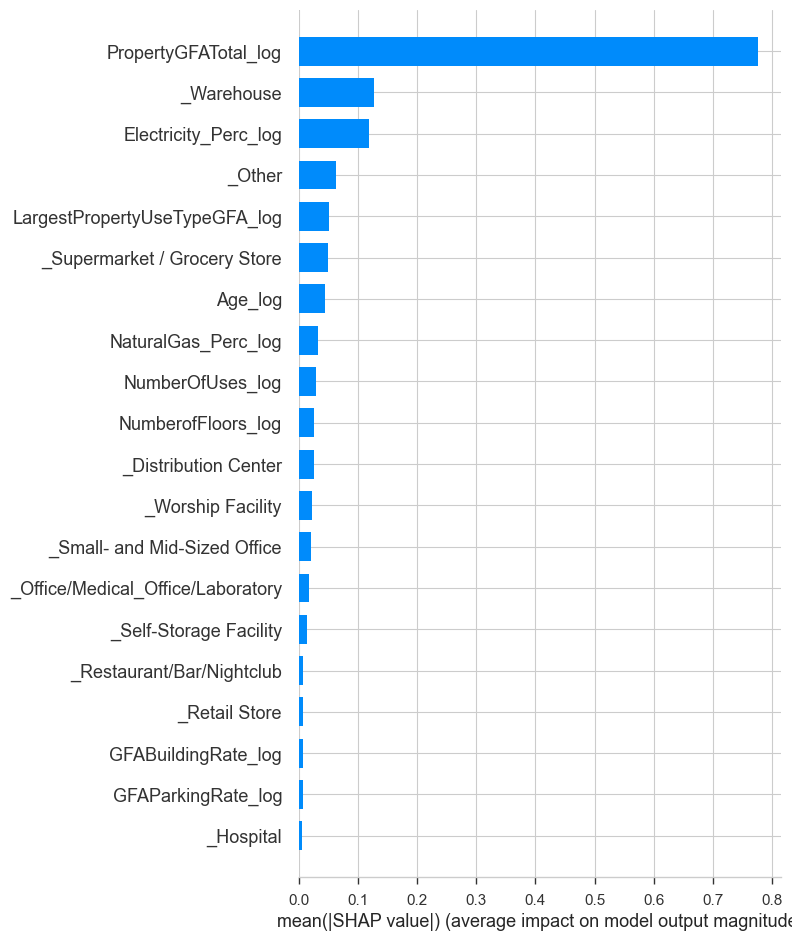

In [89]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')